In [1]:
import matplotlib.pyplot as plt
from greensight.utils import DIR_DATA
import pandas as pd
import json
import numpy as np
from datetime import datetime
from typing import Union
from pathlib import Path

In [2]:
## Establish path to unprocessed sentinel data
sentinel_data_path = DIR_DATA / "sentinel_data"
assert sentinel_data_path.is_dir()

In [3]:
for l in sentinel_data_path.iterdir():
    print(l)

/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2016
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2017
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2018
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2019
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2020
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2021
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2022
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2023
/home/finley/Work/RDS/greensight/data/sentinel_data/Greenbelts_2024


In [11]:
from typing import Callable
import re

def load_raw_data_from_dir(path: Union[str, Path], condition: Callable):
    path = Path(path)
    assert path.is_dir()

    # Extract the year using regex
    match = re.search(r"\d{4}", str(path))
    year = int(match.group(0) if match else None)

    # get all files which meet the stipulated condition
    files = sorted([file for file in path.iterdir() if condition(file)])

    # load and concatenate
    data = [pd.read_csv(file) for file in files]
    df = pd.concat(data, axis=0)

    # get unique band indentifiers
    band_inds = pd.unique([i.split("_")[1] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
    
    # get month identifiers
    month_inds = pd.unique([i.split("_")[0] for i in df.columns.unique() if i.split("_")[0].isnumeric()])

    # index by shape code
    df.index = df["LAD_CD"]

    # drop unwanted columns
    df = df.drop(columns=["system:index", ".geo"])

    months = []
    inds = []
    for month in month_inds:

        # generate desired columns
        cols = [month+"_"+band for band in band_inds]

        # create df of desired columns 
        df_month = df[cols].copy()

        # convert from a DataFrame of rows: shapes, columns: bands for a single month 
        # to a single row of rows: month, columns: (shape, band)
        row_month = df_month.stack().to_frame().T

        # create multi-index for the columns (shape, band)
        new_cols = [(a, b.split("_")[1]) for a, b in row_month.columns]
        row_month.columns = pd.MultiIndex.from_tuples(new_cols)

        # add to stack
        if row_month.shape[1] == 740:
            months.append(row_month)
            # add month name to index. 
            inds.append(month)
        else:
            # row is missing data 
            pass

    df_month = pd.concat(months, axis=0)
    df_month.index = np.array(inds).astype(int) + 1


    df_month = df_month.sort_index()
    df_month.index.name = "date"
    df_month.index = [datetime(year, int(month), 1) for month in df_month.index]
    df_month.columns.names =  ("shape", "band")

    # remove duplicate replacing with their mean- this should not be needed, but is due to a mistake in the data
    df_month = df_month.groupby(level=[0, 1], axis=1).mean()

    # add greenbelt information from json dict. 
    lookup_path = DIR_DATA / "id_lookup/id_lookup.json"
    with open(lookup_path, "r") as in_file:
        D_lookup = json.load(in_file)
    greenbelts = [D_lookup[code]["GB_Name"] for code, band in df_month.columns]

    # add greenbelts to column MultiIndex
    df_month.columns = pd.MultiIndex.from_tuples([(gb, *cols) for gb, cols in zip(greenbelts, df_month.columns)])
    df_month.columns.names =  ("greenbelt", "shape", "band")

    return df_month

df = load_raw_data_from_dir(list(sentinel_data_path.iterdir())[-1],
                          condition= lambda path: "mean" in path.stem and "S1" in path.stem)

/tmp/ipykernel_8049/427775111.py:20: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  band_inds = pd.unique([i.split("_")[1] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
/tmp/ipykernel_8049/427775111.py:23: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  month_inds = pd.unique([i.split("_")[0] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
/tmp/ipykernel_8049/427775111.py:68: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_month = df_month.groupby(level=[0, 1], axis=1).mean()


In [12]:
df.loc[:, (slice(None), "E06000049", slice(None))]


greenbelt  Stoke-on-Trent                                 
shape           E06000049                                 
band                VHAsc      VHDes      VVAsc      VVDes
2024-01-01     -17.053797 -17.198343  -9.952613  -9.987125
2024-02-01     -16.898800 -17.037409  -9.758141  -9.949314
2024-03-01     -17.133152 -17.168265  -9.789164  -9.941120
2024-04-01     -17.257944 -17.272718 -10.475674 -10.643489
2024-05-01     -17.644692 -18.036614 -11.242220 -11.508261
2024-06-01     -17.346715 -17.894954 -11.097592 -11.564001
2024-07-01     -17.404747 -18.026482 -11.223991 -11.858780
2024-08-01     -17.786270 -18.059764 -11.515791 -11.612745
2024-09-01     -17.507161 -18.035864 -10.970105 -11.403157

In [54]:
dfs = []
for path in sentinel_data_path.iterdir(): 
    df = load_raw_data_from_dir(path,
                                condition= lambda path: "mean" in path.stem and "S1" in path.stem)
    dfs.append(df)

/tmp/ipykernel_4554/3631701944.py:20: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  band_inds = pd.unique([i.split("_")[1] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
/tmp/ipykernel_4554/3631701944.py:23: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  month_inds = pd.unique([i.split("_")[0] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
/tmp/ipykernel_4554/3631701944.py:20: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  band_inds = pd.unique([i.split("_")[1] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
/tmp/ipykernel_4554/3631701944.py:23: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.

In [55]:
df_comb = pd.concat(dfs, axis=0)
df_comb.columns.names =  ("greenbelt", "shape", "band")
df_comb.head(5)

greenbelt  Bath and Bristol                                              \
shape             E06000022                                   E06000023   
band                  VHAsc      VHDes      VVAsc      VVDes      VHAsc   
2016-01-01       -16.965802 -16.730481 -10.689856 -10.475673 -15.888148   
2016-02-01       -17.365899 -16.337059 -11.055925 -10.291436 -16.257945   
2016-03-01       -17.400467 -17.124924 -10.955829 -10.733280 -16.165231   
2016-04-01       -17.468228 -17.895142 -11.703543 -11.796832 -16.237130   
2016-05-01       -18.025865 -18.837115 -12.511851 -13.399859 -16.604490   

greenbelt                                                          ...  \
shape                                        E07000187             ...   
band            VHDes      VVAsc      VVDes      VHAsc      VHDes  ...   
2016-01-01 -15.777051 -10.160175  -9.851053 -16.729187 -16.291417  ...   
2016-02-01 -15.499155 -10.539497  -9.737558 -16.927329 -16.263778  ...   
2016-03-01 -16.115408 -10.444933 -10.207245 -17.201424 -16.784729  ...   
2016-04-01 -16.565099 -10.745466 -10.819133 -16.860484 -17.569205  ...   
2016-05-01 -19.050539 -11.048362 -13.829457 -18.162007 -18.088935  ...   

greenbelt        York            South and West Yorkshire             \
shape       E07000167                           E07000169              
band            VVAsc      VVDes                    VHAsc      VHDes   
2016-01-01 -17.984797 -10.416835               -16.964244 -16.967844   
2016-02-01 -30.888702 -11.142762               -17.309828 -18.079509   
2016-03-01 -23.516490 -10.726742               -18.221808 -17.844765   
2016-04-01 -26.214073 -10.923243               -17.828457 -17.621445   
2016-05-01 -31.244051 -11.689343               -19.032648 -17.853254   

greenbelt                              York                                   
shape                             E06000014                                   
band            VVAsc      VVDes      VHAsc      VHDes      VVAsc      VVDes  
2016-01-01  -9.714359  -9.454712 -20.091480 -17.444090 -13.922106 -10.227526  
2016-02-01  -9.861789 -10.213961 -24.953243 -18.342471 -20.213084 -10.838313  
2016-03-01 -10.594095 -10.229632 -22.270042 -18.070963 -16.582783 -10.671406  
2016-04-01 -10.892269 -10.854751 -23.455521 -17.953426 -18.164070 -11.184137  
2016-05-01 -13.628585 -12.072651 -25.206759 -17.913838 -21.376690 -11.885875  

[5 rows x 740 columns]

In [91]:
output_path = DIR_DATA / "processed_data/sentinel_one_df.hdf"
df_comb.to_hdf(output_path, key="df", mode="w", format="table")


In [92]:
## check it is able to be loaded
df_loaded = pd.read_hdf(output_path, key="df")
df_loaded

greenbelt  Bath and Bristol                                              \
shape             E06000022                                   E06000023   
band                  VHAsc      VHDes      VVAsc      VVDes      VHAsc   
2016-01-01       -16.965802 -16.730481 -10.689856 -10.475673 -15.888148   
2016-02-01       -17.365899 -16.337059 -11.055925 -10.291436 -16.257945   
2016-03-01       -17.400467 -17.124924 -10.955829 -10.733280 -16.165231   
2016-04-01       -17.468228 -17.895142 -11.703543 -11.796832 -16.237130   
2016-05-01       -18.025865 -18.837115 -12.511851 -13.399859 -16.604490   
...                     ...        ...        ...        ...        ...   
2024-05-01       -18.178971 -18.519674 -12.137832 -12.109622 -16.995597   
2024-06-01       -17.792577 -18.430221 -11.631055 -12.232592 -16.852277   
2024-07-01       -17.692103 -18.396796 -11.580334 -12.154516 -16.935290   
2024-08-01       -17.642934 -17.682230 -11.317563 -11.376911 -16.668789   
2024-09-01       -18.155283 -18.799604 -11.504111 -11.888177 -17.291531   

greenbelt                                                          ...  \
shape                                        E07000187             ...   
band            VHDes      VVAsc      VVDes      VHAsc      VHDes  ...   
2016-01-01 -15.777051 -10.160175  -9.851053 -16.729187 -16.291417  ...   
2016-02-01 -15.499155 -10.539497  -9.737558 -16.927329 -16.263778  ...   
2016-03-01 -16.115408 -10.444933 -10.207245 -17.201424 -16.784729  ...   
2016-04-01 -16.565099 -10.745466 -10.819133 -16.860484 -17.569205  ...   
2016-05-01 -19.050539 -11.048362 -13.829457 -18.162007 -18.088935  ...   
...               ...        ...        ...        ...        ...  ...   
2024-05-01 -17.096603 -11.148772 -10.733330 -18.313866 -18.480772  ...   
2024-06-01 -17.115117 -10.883415 -10.776790 -17.790586 -18.342681  ...   
2024-07-01 -16.992334 -10.925775 -10.637761 -17.618527 -18.320821  ...   
2024-08-01 -16.625003 -10.571170 -10.252066 -18.852865 -17.699686  ...   
2024-09-01 -17.476544 -10.917748 -10.775075 -18.263088 -18.687853  ...   

greenbelt        York            South and West Yorkshire             \
shape       E07000167                           E07000169              
band            VVAsc      VVDes                    VHAsc      VHDes   
2016-01-01 -17.984797 -10.416835               -16.964244 -16.967844   
2016-02-01 -30.888702 -11.142762               -17.309828 -18.079509   
2016-03-01 -23.516490 -10.726742               -18.221808 -17.844765   
2016-04-01 -26.214073 -10.923243               -17.828457 -17.621445   
2016-05-01 -31.244051 -11.689343               -19.032648 -17.853254   
...               ...        ...                      ...        ...   
2024-05-01 -11.574302 -11.968799               -18.866101 -19.040437   
2024-06-01 -11.269097 -11.758631               -18.281998 -18.492164   
2024-07-01 -10.911978 -11.790588               -17.728315 -18.442906   
2024-08-01 -11.737792 -12.330654               -19.561872 -20.108010   
2024-09-01 -10.392184 -10.521659               -18.618468 -18.203613   

greenbelt                              York                                   
shape                             E06000014                                   
band            VVAsc      VVDes      VHAsc      VHDes      VVAsc      VVDes  
2016-01-01  -9.714359  -9.454712 -20.091480 -17.444090 -13.922106 -10.227526  
2016-02-01  -9.861789 -10.213961 -24.953243 -18.342471 -20.213084 -10.838313  
2016-03-01 -10.594095 -10.229632 -22.270042 -18.070963 -16.582783 -10.671406  
2016-04-01 -10.892269 -10.854751 -23.455521 -17.953426 -18.164070 -11.184137  
2016-05-01 -13.628585 -12.072651 -25.206759 -17.913838 -21.376690 -11.885875  
...               ...        ...        ...        ...        ...        ...  
2024-05-01 -12.409031 -12.491690 -18.537215 -18.936246 -11.910192 -12.242950  
2024-06-01 -12.073991 -12.291409 -17.981412 -18.510452 -11.594448 -12.069527  
2024-07-01 -11.587789 -12.408398 -

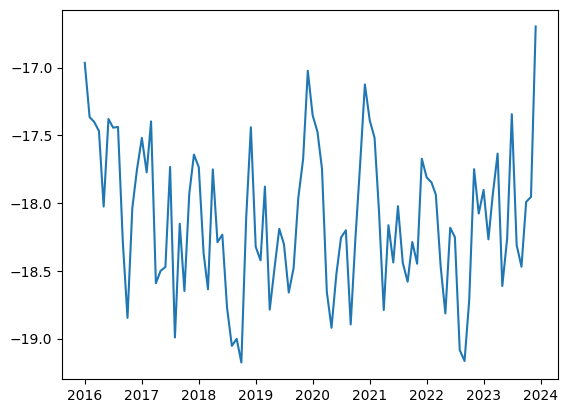

In [25]:
plt.plot(df_comb.index, df_comb["Bath and Bristol"]["E06000022"]["VHAsc"])

In [10]:
out[0].columns

MultiIndex([('E06000022', 'VHAsc'),
            ('E06000022', 'VHDes'),
            ('E06000022', 'VVAsc'),
            ('E06000022', 'VVDes'),
            ('E06000023', 'VHAsc'),
            ('E06000023', 'VHDes'),
            ('E06000023', 'VVAsc'),
            ('E06000023', 'VVDes'),
            ('E07000187', 'VHAsc'),
            ('E07000187', 'VHDes'),
            ...
            ('E07000167', 'VVAsc'),
            ('E07000167', 'VVDes'),
            ('E07000169', 'VHAsc'),
            ('E07000169', 'VHDes'),
            ('E07000169', 'VVAsc'),
            ('E07000169', 'VVDes'),
            ('E06000014', 'VHAsc'),
            ('E06000014', 'VHDes'),
            ('E06000014', 'VVAsc'),
            ('E06000014', 'VVDes')],
           length=740)

In [11]:
out[1].columns

MultiIndex([('E06000022', 'VHAsc'),
            ('E06000022', 'VHDes'),
            ('E06000022', 'VVAsc'),
            ('E06000022', 'VVDes'),
            ('E06000023', 'VHAsc'),
            ('E06000023', 'VHDes'),
            ('E06000023', 'VVAsc'),
            ('E06000023', 'VVDes'),
            ('E07000187', 'VHAsc'),
            ('E07000187', 'VHDes'),
            ...
            ('E07000167', 'VVAsc'),
            ('E07000167', 'VVDes'),
            ('E07000169', 'VHAsc'),
            ('E07000169', 'VHDes'),
            ('E07000169', 'VVAsc'),
            ('E07000169', 'VVDes'),
            ('E06000014', 'VHAsc'),
            ('E06000014', 'VHDes'),
            ('E06000014', 'VVAsc'),
            ('E06000014', 'VVDes')],
           length=740)

In [15]:
pd.concat(out[:-1], axis=0)

E06000022                                   E06000023             \
       VHAsc      VHDes      VVAsc      VVDes      VHAsc      VHDes   
0 -17.844681 -17.724548 -11.019564 -10.835481 -16.603732 -16.224713   
0 -17.092741 -17.340628 -10.477712 -10.652393 -15.986650 -15.959430   
0 -17.490266 -17.712028 -10.925572 -10.994889 -16.232959 -16.289004   
0 -17.671621 -18.143137 -11.354970 -11.742977 -16.549188 -16.659302   
0 -18.178971 -18.519674 -12.137832 -12.109622 -16.995597 -17.096603   
0 -17.792577 -18.430221 -11.631055 -12.232592 -16.852277 -17.115117   
0 -17.692103 -18.396796 -11.580334 -12.154516 -16.935290 -16.992334   
0 -17.642934 -17.682230 -11.317563 -11.376911 -16.668789 -16.625003   
0 -18.155283 -18.799604 -11.504111 -11.888177 -17.291531 -17.476544   

                         E07000187             ...  E07000167             \
       VVAsc      VVDes      VHAsc      VHDes  ...      VVAsc      VVDes   
0 -10.676191 -10.141456 -17.889427 -17.798883  ... -10.824427 -11.114084   
0 -10.088565  -9.934619 -17.129966 -17.213599  ... -10.146488 -10.349738   
0 -10.384118 -10.252792 -17.431801 -17.608697  ... -10.472834 -11.071979   
0 -10.707358 -10.543841 -17.550717 -17.793188  ... -10.619023 -10.947715   
0 -11.148772 -10.733330 -18.313866 -18.480772  ... -11.574302 -11.968799   
0 -10.883415 -10.776790 -17.790586 -18.342681  ... -11.269097 -11.758631   
0 -10.925775 -10.637761 -17.618527 -18.320821  ... -10.911978 -11.790588   
0 -10.571170 -10.252066 -18.852865 -17.699686  ... -11.737792 -12.330654   
0 -10.917748 -10.775075 -18.263088 -18.687853  ... -10.392184 -10.521659   

   E07000169                                   E06000014             \
       VHAsc      VHDes      VVAsc      VVDes      VHAsc      VHDes   
0 -18.697087 -18.984591 -10.591589 -10.676784 -18.663880 -19.052379   
0 -18.122473 -17.502843 -10.219040  -9.827587 -18.264846 -17.864834   
0 -18.537736 -18.514524 -10.540737 -10.580831 -18.474839 -18.822311   
0 -18.761171 -18.265049 -11.466620 -11.082604 -18.463820 -18.492969   
0 -18.866101 -19.040437 -12.409031 -12.491690 -18.537215 -18.936246   
0 -18.281998 -18.492164 -12.073991 -12.291409 -17.981412 -18.510452   
0 -17.728315 -18.442906 -11.587789 -12.408398 -17.897072 -18.674193   
0 -19.561872 -20.108010 -12.127926 -12.660774 -19.351545 -19.933072   
0 -18.618468 -18.203613 -10.770576 -10.541067 -18.531950 -18.643274   

                         
       VVAsc      VVDes  
0 -11.052906 -11.254732  
0 -10.485558 -10.500218  
0 -10.698619 -11.103476  
0 -11.116933 -11.285850  
0 -11.910192 -12.242950  
0 -11.594448 -12.069527  
0 -11.519807 -12.320725  
0 -12.120920 -12.774026  
0 -11.120198 -11.293498  

[9 rows x 740 columns]

In [12]:
out[2].columns

MultiIndex([('E06000022', 'VHAsc'),
            ('E06000022', 'VHDes'),
            ('E06000022', 'VVAsc'),
            ('E06000022', 'VVDes'),
            ('E06000023', 'VHAsc'),
            ('E06000023', 'VHDes'),
            ('E06000023', 'VVAsc'),
            ('E06000023', 'VVDes'),
            ('E07000187', 'VHAsc'),
            ('E07000187', 'VHDes'),
            ...
            ('E07000167', 'VVAsc'),
            ('E07000167', 'VVDes'),
            ('E07000169', 'VHAsc'),
            ('E07000169', 'VHDes'),
            ('E07000169', 'VVAsc'),
            ('E07000169', 'VVDes'),
            ('E06000014', 'VHAsc'),
            ('E06000014', 'VHDes'),
            ('E06000014', 'VVAsc'),
            ('E06000014', 'VVDes')],
           length=740)

In [24]:
print(len(out[0].columns))
print(len(out[-1].columns))

740
658


In [6]:
out[0]

E06000022                                   E06000023             \
       VHAsc      VHDes      VVAsc      VVDes      VHAsc      VHDes   
0 -17.844681 -17.724548 -11.019564 -10.835481 -16.603732 -16.224713   

                         E07000187             ...  E07000167             \
       VVAsc      VVDes      VHAsc      VHDes  ...      VVAsc      VVDes   
0 -10.676191 -10.141456 -17.889427 -17.798883  ... -10.824427 -11.114084   

   E07000169                                  E06000014                        \
       VHAsc      VHDes      VVAsc      VVDes     VHAsc      VHDes      VVAsc   
0 -18.697087 -18.984591 -10.591589 -10.676784 -18.66388 -19.052379 -11.052906   

              
       VVDes  
0 -11.254732  

[1 rows x 740 columns]

In [17]:
out[-1]

E06000022             E06000023             E07000187             \
       VHAsc      VVAsc      VHAsc      VVAsc      VHAsc      VVAsc   
0 -18.490912 -11.622237 -17.384956 -10.999913 -18.738882 -11.415326   

   E06000024             E06000025             ... E07000167             \
       VHAsc      VVAsc      VHAsc      VVAsc  ...     VVAsc      VVDes   
0 -17.979071 -11.509561 -18.161879 -11.381991  ... -9.097837 -11.641049   

   E07000169                                 E06000014                       \
       VHAsc      VHDes     VVAsc     VVDes      VHAsc      VHDes     VVAsc   
0 -17.558882 -19.345808 -9.815322 -11.21518 -17.232725 -19.642664 -10.06065   

              
       VVDes  
0 -11.989698  

[1 rows x 658 columns]

In [19]:
out[-1].columns.shape

(658,)

In [26]:
va = [i for i, _ in out[-1].columns]
va

['E06000022',
 'E06000022',
 'E06000023',
 'E06000023',
 'E07000187',
 'E07000187',
 'E06000024',
 'E06000024',
 'E06000025',
 'E06000025',
 'E06000054',
 'E06000054',
 'E08000025',
 'E08000025',
 'E07000234',
 'E07000234',
 'E07000192',
 'E07000192',
 'E08000026',
 'E08000026',
 'E08000027',
 'E08000027',
 'E07000194',
 'E07000194',
 'E07000218',
 'E07000218',
 'E07000219',
 'E07000219',
 'E07000236',
 'E07000236',
 'E07000220',
 'E07000220',
 'E08000028',
 'E08000028',
 'E06000051',
 'E06000051',
 'E08000029',
 'E08000029',
 'E07000196',
 'E07000196',
 'E07000197',
 'E07000197',
 'E07000221',
 'E07000221',
 'E07000199',
 'E07000199',
 'E08000030',
 'E08000030',
 'E07000222',
 'E07000222',
 'E08000031',
 'E08000031',
 'E07000237',
 'E07000237',
 'E07000238',
 'E07000238',
 'E07000239',
 'E07000239',
 'E06000009',
 'E06000009',
 'E07000119',
 'E07000119',
 'E07000128',
 'E07000128',
 'E07000193',
 'E07000193',
 'E07000039',
 'E07000039',
 'E07000008',
 'E07000008',
 'E07000009',
 'E070

In [32]:
[i for i in out[0].columns if i not in out[-1].columns]

/tmp/ipykernel_72417/776098438.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  [i for i in out[0].columns if i not in out[-1].columns]


[('E06000022', 'VHDes'),
 ('E06000022', 'VVDes'),
 ('E06000023', 'VHDes'),
 ('E06000023', 'VVDes'),
 ('E07000187', 'VHDes'),
 ('E07000187', 'VVDes'),
 ('E06000024', 'VHDes'),
 ('E06000024', 'VVDes'),
 ('E06000025', 'VHDes'),
 ('E06000025', 'VVDes'),
 ('E06000054', 'VHDes'),
 ('E06000054', 'VVDes'),
 ('E08000025', 'VHDes'),
 ('E08000025', 'VVDes'),
 ('E07000234', 'VHDes'),
 ('E07000234', 'VVDes'),
 ('E07000192', 'VHDes'),
 ('E07000192', 'VVDes'),
 ('E08000026', 'VHDes'),
 ('E08000026', 'VVDes'),
 ('E08000027', 'VHDes'),
 ('E08000027', 'VVDes'),
 ('E07000194', 'VHDes'),
 ('E07000194', 'VVDes'),
 ('E07000218', 'VHDes'),
 ('E07000218', 'VVDes'),
 ('E07000219', 'VHDes'),
 ('E07000219', 'VVDes'),
 ('E07000236', 'VHDes'),
 ('E07000236', 'VVDes'),
 ('E07000220', 'VHDes'),
 ('E07000220', 'VVDes'),
 ('E08000028', 'VHDes'),
 ('E08000028', 'VVDes'),
 ('E06000051', 'VHDes'),
 ('E06000051', 'VVDes'),
 ('E08000029', 'VHDes'),
 ('E08000029', 'VVDes'),
 ('E07000196', 'VHDes'),
 ('E07000196', 'VVDes'),


In [31]:
a.shape

(658,)

In [28]:
[i for i in vb if i not in va]

[]

In [22]:
out[-1].columns.values.shape

(658,)

In [18]:
[i for i, a in out[0].columns if i in out[-1].columns]

['E06000022',
 'E06000022',
 'E06000022',
 'E06000022',
 'E06000023',
 'E06000023',
 'E06000023',
 'E06000023',
 'E07000187',
 'E07000187',
 'E07000187',
 'E07000187',
 'E06000024',
 'E06000024',
 'E06000024',
 'E06000024',
 'E06000025',
 'E06000025',
 'E06000025',
 'E06000025',
 'E06000054',
 'E06000054',
 'E06000054',
 'E06000054',
 'E08000025',
 'E08000025',
 'E08000025',
 'E08000025',
 'E07000234',
 'E07000234',
 'E07000234',
 'E07000234',
 'E07000192',
 'E07000192',
 'E07000192',
 'E07000192',
 'E08000026',
 'E08000026',
 'E08000026',
 'E08000026',
 'E08000027',
 'E08000027',
 'E08000027',
 'E08000027',
 'E07000194',
 'E07000194',
 'E07000194',
 'E07000194',
 'E07000218',
 'E07000218',
 'E07000218',
 'E07000218',
 'E07000219',
 'E07000219',
 'E07000219',
 'E07000219',
 'E07000236',
 'E07000236',
 'E07000236',
 'E07000236',
 'E07000220',
 'E07000220',
 'E07000220',
 'E07000220',
 'E08000028',
 'E08000028',
 'E08000028',
 'E08000028',
 'E06000051',
 'E06000051',
 'E06000051',
 'E060

In [14]:
out[-1].columns.values

array([('E06000022', 'VHAsc'), ('E06000022', 'VVAsc'),
       ('E06000023', 'VHAsc'), ('E06000023', 'VVAsc'),
       ('E07000187', 'VHAsc'), ('E07000187', 'VVAsc'),
       ('E06000024', 'VHAsc'), ('E06000024', 'VVAsc'),
       ('E06000025', 'VHAsc'), ('E06000025', 'VVAsc'),
       ('E06000054', 'VHAsc'), ('E06000054', 'VVAsc'),
       ('E08000025', 'VHAsc'), ('E08000025', 'VVAsc'),
       ('E07000234', 'VHAsc'), ('E07000234', 'VVAsc'),
       ('E07000192', 'VHAsc'), ('E07000192', 'VVAsc'),
       ('E08000026', 'VHAsc'), ('E08000026', 'VVAsc'),
       ('E08000027', 'VHAsc'), ('E08000027', 'VVAsc'),
       ('E07000194', 'VHAsc'), ('E07000194', 'VVAsc'),
       ('E07000218', 'VHAsc'), ('E07000218', 'VVAsc'),
       ('E07000219', 'VHAsc'), ('E07000219', 'VVAsc'),
       ('E07000236', 'VHAsc'), ('E07000236', 'VVAsc'),
       ('E07000220', 'VHAsc'), ('E07000220', 'VVAsc'),
       ('E08000028', 'VHAsc'), ('E08000028', 'VVAsc'),
       ('E06000051', 'VHAsc'), ('E06000051', 'VVAsc'),
       ('E

In [7]:
out[-1]

E06000022             E06000023             E07000187             \
       VHAsc      VVAsc      VHAsc      VVAsc      VHAsc      VVAsc   
0 -18.490912 -11.622237 -17.384956 -10.999913 -18.738882 -11.415326   

   E06000024             E06000025             ... E07000167             \
       VHAsc      VVAsc      VHAsc      VVAsc  ...     VVAsc      VVDes   
0 -17.979071 -11.509561 -18.161879 -11.381991  ... -9.097837 -11.641049   

   E07000169                                 E06000014                       \
       VHAsc      VHDes     VVAsc     VVDes      VHAsc      VHDes     VVAsc   
0 -17.558882 -19.345808 -9.815322 -11.21518 -17.232725 -19.642664 -10.06065   

              
       VVDes  
0 -11.989698  

[1 rows x 658 columns]

In [5]:
out = load_raw_data_from_dir(list(sentinel_data_path.iterdir())[-1],
                             condition= lambda path: "mean" in path.stem and "S1" in path.stem)

/tmp/ipykernel_72417/3378733742.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  band_inds = pd.unique([i.split("_")[1] for i in df.columns.unique() if i.split("_")[0].isnumeric()])
/tmp/ipykernel_72417/3378733742.py:23: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  month_inds = pd.unique([i.split("_")[0] for i in df.columns.unique() if i.split("_")[0].isnumeric()])


In [58]:
df_month.T.groupby(["greenbelt"]).mean().T

greenbelt,Bath and Bristol,Birmingham,Blackpool,Burton-upon-Trent and Swadlincote,Cambridge,"Carnforth, Lancaster and Morecambe",Cheltenham and Gloucester,Derby and Nottingham,London,Merseyside and Greater Manchester,Oxford,South West Hampshire,South and West Yorkshire,Stoke-on-Trent,Tyne and Wear,York
2023-01-01,-13.739524,-13.503794,-14.294206,-13.644647,-13.960476,-14.125535,-13.543314,-13.955883,-13.428986,-13.439101,-14.124697,-14.010271,-13.930477,-13.328012,-13.752796,-13.941203
2023-02-01,-13.729828,-13.413875,-14.454111,-13.411663,-14.102796,-14.178512,-13.474980,-13.807913,-13.351459,-13.349124,-14.175748,-13.882474,-13.668240,-13.070128,-13.655620,-14.023950
2023-03-01,-14.276180,-14.217116,-14.734309,-14.257726,-15.192453,-14.805378,-14.027860,-14.635054,-13.773939,-14.060952,-14.654928,-14.283405,-14.744190,-13.864337,-14.858715,-15.188906
2023-04-01,-15.193873,-15.214884,-15.803579,-15.874698,-16.679042,-16.268695,-14.851458,-15.653115,-14.772714,-15.306442,-15.489028,-14.833486,-15.909405,-14.923637,-15.888266,-16.563162
2023-05-01,-15.764516,-15.723209,-16.386782,-16.351283,-17.142421,-16.629849,-15.410433,-16.203472,-15.266562,-15.855218,-16.136002,-15.409845,-16.443399,-15.557635,-16.053994,-16.531603
2023-06-01,-15.194258,-14.977242,-15.463266,-15.489797,-15.625045,-15.900296,-14.819097,-15.221035,-14.845222,-14.958627,-15.626192,-15.045101,-15.281364,-14.780276,-15.148767,-15.363460
2023-07-01,-14.983564,-14.705509,-15.092393,-15.245760,-15.242838,-15.520524,-14.777305,-15.015199,-14.710210,-14.503277,-15.230553,-15.049506,-15.073841,-14.354794,-15.132094,-14.956859
2023-08-01,-14.940943,-14.907816,-15.250759,-15.036322,-15.527222,-15.470029,-14.847183,-15.206750,-14.716737,-14.606713,-15.299808,-14.944356,-15.124424,-14.681483,-14.905806,-14.971321
2023-09-01,-15.342070,-15.209663,-15.401358,-15.570410,-15.636610,-15.559771,-15.155911,-15.598032,-14.911800,-14.906866,-15.644267,-15.093739,-15.416528,-14.891734,-15.100193,-15.116593
2023-10-01,-14.394015,-14.177003,-14.903826,-14.240510,-13.911279,-15.222456,-14.240431,-14.625265,-13.735618,-14.145376,-14.336051,-14.055694,-14.512726,-14.099857,-14.219515,-14.073740


In [62]:
from greensight.utils import DIR_ROOT
path_soil_carbon = DIR_ROOT / "share_point/data/JULES_outputs/Level_0_original_outputs/TW_UK_ERA5_BASE_V2_greenbelt16_ts_soil_carbon_interp_final__v1.xlsx"
path_veg_carbon = DIR_ROOT / "share_point/data/JULES_outputs/Level_0_original_outputs/TW_UK_ERA5_BASE_V2_greenbelt16_ts_vegetation_carbon_interp_final__v1.xlsx"
assert path_soil_carbon.is_file()
assert path_veg_carbon.is_file()

In [63]:
df_soil_raw = pd.read_excel(path_soil_carbon)
df_veg_raw = pd.read_excel(path_veg_carbon)

In [64]:
df_soil_raw

,YrMthDay,year,mth_nr,,day_of_month,MthDay,Yr_mth_nr,Bath_and_Bristol_cs_gb_TW_UK_ERA5_BASE_V2,Birmingham_cs_gb_TW_UK_ERA5_BASE_V2,Blackpool_cs_gb_TW_UK_ERA5_BASE_V2,...,Cheltenham_and_Gloucester_cs_gb_TW_UK_ERA5_BASE_V2,Derby_and_Nottingham_cs_gb_TW_UK_ERA5_BASE_V2,London_cs_gb_TW_UK_ERA5_BASE_V2,Merseyside_and_Greater_Manchester_cs_gb_TW_UK_ERA5_BASE_V2,Oxford_cs_gb_TW_UK_ERA5_BASE_V2,South_West_Hampshire_cs_gb_TW_UK_ERA5_BASE_V2,South_and_West_Yorkshire_cs_gb_TW_UK_ERA5_BASE_V2,Stoke_on_Trent_cs_gb_TW_UK_ERA5_BASE_V2,Tyne_and_Wear_cs_gb_TW_UK_ERA5_BASE_V2,York_cs_gb_TW_UK_ERA5_BASE_V2
0,19700102,1970,1,Jan,2,102,1970_1,21.377278,18.247952,9.128355,...,17.566530,18.697467,21.809056,13.982956,22.056664,18.794014,17.213288,19.379328,17.951353,16.958119
1,19700103,1970,1,Jan,3,103,1970_1,21.376281,18.247033,9.127896,...,17.565801,18.696422,21.808157,13.982309,22.055550,18.793039,17.212433,19.378410,17.950424,16.957254
2,19700104,1970,1,Jan,4,104,1970_1,21.375373,18.246093,9.127416,...,17.565089,18.695352,21.807337,13.981649,22.054508,18.792190,17.211585,19.377469,17.949498,16.956414
3,19700105,1970,1,Jan,5,105,1970_1,21.374386,18.245097,9.126928,...,17.564296,18.694241,21.806393,13.980960,22.053376,18.791255,17.210724,19.376480,17.948648,16.955585
4,19700106,1970,1,Jan,6,106,1970_1,21.373674,18.244349,9.126500,...,17.563587,18.693422,21.805819,13.980355,22.052553,18.790466,17.210052,19.375642,17.948066,16.954877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19718,20231228,2023,12,Dec,28,1228,2023_12,20.461636,17.674745,8.977008,...,16.835374,18.131897,21.370139,13.702212,21.396314,18.160502,16.811104,18.864341,17.727888,16.625345
19719,20231229,2023,12,Dec,29,1229,2023_12,20.459830,17.673811,8.976380,...,16.834282,18.130862,21.368519,13.701628,21.394676,18.158678,16.810433,18.863568,17.726827,16.624515
19720,20231230,2023,12,Dec,30,1230,2023_12,20.458323,17.672470,8.975719,...,16.833196,18.129475,21.366736,13.700768,21.392996,18.157119,16.809422,18.862355,17.725768,16.623371
19721,20231231,2023,12,Dec,31,1231,2023_12,20.457463,17.671711,8.975220,...,16.832407,18.128613,21.365466,13.700338,21.391737,18.155668,16.808910,18.861775,17.724678,16.622670


In [65]:
def convert_df_dates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.replace(" ", "") for c in df.columns]
    df.insert(0, "date", df["YrMthDay"].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date()))
    df = df.set_index("date")
    try:
        return df.drop(columns=["YrMthDay", "year", "mth_nr", "", "day_of_month", "MthDay", "Yr_mth_nr"])
    except KeyError:
        return df.drop(columns=["YrMthDay", "year", "mth_nr", "mth", "day_of_month", "MthDay", "Yr_mth_nr"])

In [66]:
df_soil = convert_df_dates(df_soil_raw)
df_veg = convert_df_dates(df_veg_raw)

In [67]:
df_soil

,Bath_and_Bristol_cs_gb_TW_UK_ERA5_BASE_V2,Birmingham_cs_gb_TW_UK_ERA5_BASE_V2,Blackpool_cs_gb_TW_UK_ERA5_BASE_V2,Burton_upon_Trent_and_Swadlincote_cs_gb_TW_UK_ERA5_BASE_V2,Cambridge_cs_gb_TW_UK_ERA5_BASE_V2,Carnforth_Lancaster_and_Morecambe_cs_gb_TW_UK_ERA5_BASE_V2,Cheltenham_and_Gloucester_cs_gb_TW_UK_ERA5_BASE_V2,Derby_and_Nottingham_cs_gb_TW_UK_ERA5_BASE_V2,London_cs_gb_TW_UK_ERA5_BASE_V2,Merseyside_and_Greater_Manchester_cs_gb_TW_UK_ERA5_BASE_V2,Oxford_cs_gb_TW_UK_ERA5_BASE_V2,South_West_Hampshire_cs_gb_TW_UK_ERA5_BASE_V2,South_and_West_Yorkshire_cs_gb_TW_UK_ERA5_BASE_V2,Stoke_on_Trent_cs_gb_TW_UK_ERA5_BASE_V2,Tyne_and_Wear_cs_gb_TW_UK_ERA5_BASE_V2,York_cs_gb_TW_UK_ERA5_BASE_V2
date,,,,,,,,,,,,,,,,
1970-01-02,21.377278,18.247952,9.128355,16.191114,17.290410,8.776074,17.566530,18.697467,21.809056,13.982956,22.056664,18.794014,17.213288,19.379328,17.951353,16.958119
1970-01-03,21.376281,18.247033,9.127896,16.190207,17.289599,8.775647,17.565801,18.696422,21.808157,13.982309,22.055550,18.793039,17.212433,19.378410,17.950424,16.957254
1970-01-04,21.375373,18.246093,9.127416,16.189249,17.288805,8.775220,17.565089,18.695352,21.807337,13.981649,22.054508,18.792190,17.211585,19.377469,17.949498,16.956414
1970-01-05,21.374386,18.245097,9.126928,16.188261,17.287912,8.774777,17.564296,18.694241,21.806393,13.980960,22.053376,18.791255,17.210724,19.376480,17.948648,16.955585
1970-01-06,21.373674,18.244349,9.126500,16.187513,17.287249,8.774369,17.563587,18.693422,21.805819,13.980355,22.052553,18.790466,17.210052,19.375642,17.948066,16.954877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,20.461636,17.674745,8.977008,15.539211,16.922400,8.643285,16.835374,18.131897,21.370139,13.702212,21.396314,18.160502,16.811104,18.864341,17.727888,16.625345
2023-12-29,20.459830,17.673811,8.976380,15.538400,16.921161,8.642900,16.834282,18.130862,21.368519,13.701628,21.394676,18.158678,16.810433,18.863568,17.726827,16.624515
2023-12-30,20.458323,17.672470,8.975719,15.537228,16.919826,8.642297,16.833196,18.129475,21.366736,13.700768,21.392996,18.157119,16.809422,18.862355,17.725768,16.623371


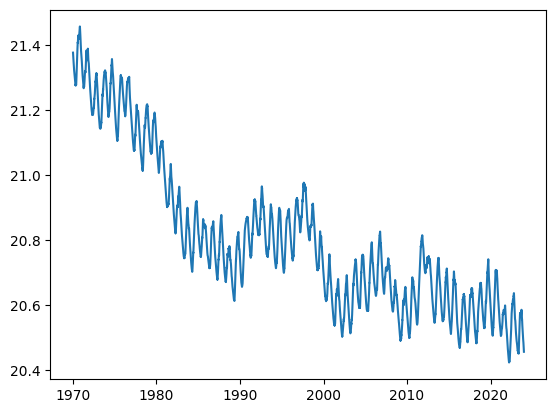

In [68]:
plt.plot(df_soil["Bath_and_Bristol_cs_gb_TW_UK_ERA5_BASE_V2"])

In [89]:
df_month

greenbelt      London                                                         \
shape       E07000069                                   E06000056              
band            VHAsc      VHDes      VVAsc      VVDes      VHAsc      VHDes   
2023-01-01 -16.778835 -17.312853 -10.172749 -10.664315 -17.051352 -17.247376   
2023-02-01 -16.390049 -17.366932  -9.761694 -10.698326 -17.012696 -17.631761   
2023-03-01 -16.834113 -17.528024 -10.238020 -10.767711 -18.155462 -18.541949   
2023-04-01 -17.752768 -18.347327 -11.354072 -11.703007 -19.498620 -19.026627   
2023-05-01 -18.228127 -18.690014 -11.786345 -12.010240 -19.292210 -19.720256   
2023-06-01 -17.772866 -17.971389 -11.463166 -11.466257 -18.689826 -18.529176   
2023-07-01 -17.291019 -18.559946 -10.814775 -11.916069 -17.654853 -18.312924   
2023-08-01 -17.860518 -18.241809 -11.178987 -11.457428 -18.835555 -18.349956   
2023-09-01 -17.742282 -18.493318 -10.964430 -11.548821 -18.811556 -19.339046   
2023-10-01 -16.974294 -17.160479 -10.216855 -10.397116 -17.136163 -17.133909   
2023-11-01 -17.031149 -17.389315 -10.375835 -10.700087 -17.581313 -17.361538   
2023-12-01 -16.325123 -16.834401  -9.694445 -10.302902 -16.366412 -16.866768   

greenbelt                                               ...             \
shape                             E07000070             ...  E09000006   
band            VVAsc      VVDes      VHAsc      VHDes  ...      VVAsc   
2023-01-01  -9.667882  -9.789490 -17.001420 -17.426289  ...  -9.568596   
2023-02-01  -9.366410  -9.777669 -16.848178 -17.795053  ...  -9.151191   
2023-03-01 -10.238391 -10.542699 -18.038819 -18.228697  ...  -9.711555   
2023-04-01 -12.159923 -11.718128 -19.307181 -19.735219  ... -11.115161   
2023-05-01 -12.682211 -13.099320 -19.332462 -19.694910  ... -11.678085   
2023-06-01 -12.620846 -12.399021 -18.799489 -18.767735  ... -11.548085   
2023-07-01 -11.473991 -12.181900 -17.971632 -19.361995  ... -11.069997   
2023-08-01 -11.692658 -11.551471 -19.597006 -19.293660  ... -11.064883   
2023-09-01 -11.254459 -11.723289 -19.382078 -19.791161  ... -11.057038   
2023-10-01  -9.957412  -9.933194 -17.787850 -17.606315  ... -10.175508   
2023-11-01 -10.093238  -9.939364 -17.845331 -17.988839  ...  -9.970403   
2023-12-01  -9.329600  -9.545254 -16.735593 -17.118110  ...  -9.346247   

greenbelt                                                                     \
shape                  E07000095                                   E06000060   
band            VVDes      VHAsc      VHDes      VVAsc      VVDes      VHAsc   
2023-01-01 -10.417717 -16.186994 -17.022973  -9.716832 -10.605720 -16.793762   
2023-02-01 -10.504155 -16.018910 -17.283384  -9.397219 -10.778476 -16.779271   
2023-03-01 -10.427534 -16.504440 -17.209423  -9.837122 -10.654823 -17.205031   
2023-04-01 -11.832990 -17.459056 -18.317353 -10.935587 -11.760504 -18.241492   
2023-05-01 -12.354758 -18.058243 -18.862767 -11.467226 -12.253585 -18.533797   
2023-06-01 -11.973270 -17.739454 -18.179171 -11.412288 -11.774137 -18.256633   
2023-07-01 -12.212530 -17.252575 -18.464406 -10.853184 -11.997154 -17.676841   
2023-08-01 -11.700458 -17.568854 -17.823486 -10.874086 -11.303393 -18.252609   
2023-09-01 -11.976488 -17.720735 -18.508467 -10.873700 -11.701083 -18.360413   
2023-10-01 -10.743990 -16.905093 -17.356602 -10.191428 -10.682880 -17.514310   
2023-11-01 -10.507205 -16.528394 -17.036040 -10.003190 -10.632043 -17.344838   
2023-12-01 -10.200482 -15.843322 -16.537284  -9.315165 -10.233964 -16.660231   

greenbelt                                    
shape                                        
band            VHDes      VVAsc      VVDes  
2023-01-01 -16.711895 -10.276120  -9.872232  
2023-02-01 -16.739678 -10.036190  -9.693177  
2023-03-01 -17.460376 -10.433339 -10.268756  
2023-04-01 -17.940814 -11.723280 -11.111340  
2023-05-01 -18.872973 -12.168032 -12.240680  
2023-06-01 -18.015888 -12.078796 -11.572473  
2023-07-01 -17.845892 -11.389265 -11.399555  
2023-08-01 -17.865721 -11.4

In [96]:
df_mean = df_month.groupby(level=["greenbelt", "band"], axis=1).mean()
df_mean

/tmp/ipykernel_4048/424505169.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_mean = df_month.groupby(level=["greenbelt", "band"], axis=1).mean()


greenbelt  Bath and Bristol                                  Birmingham  \
band                  VHAsc      VHDes      VVAsc      VVDes      VHAsc   
2023-01-01       -17.063447 -17.015980 -10.472248 -10.406420 -16.720064   
2023-02-01       -17.178569 -17.010586 -10.388651 -10.341507 -16.815751   
2023-03-01       -17.434131 -18.038204 -10.645885 -10.986500 -17.386342   
2023-04-01       -18.332304 -18.501672 -11.981760 -11.959756 -18.585843   
2023-05-01       -18.648375 -19.161320 -12.472813 -12.775556 -18.653995   
2023-06-01       -18.205271 -18.396681 -12.062719 -12.112362 -18.059172   
2023-07-01       -18.040416 -18.200179 -11.765457 -11.928204 -17.482203   
2023-08-01       -18.110506 -18.268950 -11.663198 -11.721119 -18.004730   
2023-09-01       -18.622803 -18.852054 -11.888251 -12.005172 -18.443575   
2023-10-01       -18.063005 -17.424331 -11.291118 -10.797608 -17.599338   
2023-11-01       -17.420555 -17.166605 -10.861590 -10.652703 -17.228026   
2023-12-01       -16.875609 -17.314260 -10.383831 -10.700568 -16.532676   

greenbelt                                    Blackpool             ...  \
band            VHDes      VVAsc      VVDes      VHAsc      VHDes  ...   
2023-01-01 -17.203546  -9.742000 -10.349567 -17.668595 -17.849564  ...   
2023-02-01 -17.161735  -9.484772 -10.193242 -17.950652 -18.196969  ...   
2023-03-01 -18.434666  -9.989597 -11.057858 -17.982614 -18.827118  ...   
2023-04-01 -18.779468 -11.614619 -11.879606 -18.859751 -19.459026  ...   
2023-05-01 -19.408209 -12.046788 -12.783843 -19.354952 -19.878028  ...   
2023-06-01 -18.234531 -11.750489 -11.864778 -18.617698 -18.724543  ...   
2023-07-01 -18.292323 -11.099273 -11.948238 -18.264155 -18.459184  ...   
2023-08-01 -18.546235 -11.251750 -11.828547 -18.408011 -18.609787  ...   
2023-09-01 -19.068408 -11.339065 -11.987604 -18.439599 -19.140061  ...   
2023-10-01 -17.757257 -10.533474 -10.817943 -18.134813 -18.540294  ...   
2023-11-01 -17.571137 -10.261839 -10.727571 -17.795677 -18.183337  ...   
2023-12-01 -17.441837  -9.657014 -10.511389 -17.949281 -18.652290  ...   

greenbelt  Stoke-on-Trent            Tyne and Wear                        \
band                VVAsc      VVDes         VHAsc      VHDes      VVAsc   
2023-01-01     -10.028052 -10.126925    -17.630769 -17.422390 -10.309183   
2023-02-01      -9.563408  -9.875168    -17.688689 -17.246226 -10.102426   
2023-03-01      -9.991354 -10.715813    -18.804833 -18.937867 -11.007817   
2023-04-01     -11.524456 -11.895686    -19.469252 -19.446358 -12.452293   
2023-05-01     -12.335773 -12.556961    -19.467645 -19.311340 -12.927923   
2023-06-01     -11.850038 -11.545191    -18.565037 -17.964582 -12.412407   
2023-07-01     -11.211118 -11.418356    -18.502438 -18.041905 -12.202119   
2023-08-01     -11.477852 -11.637578    -18.477669 -17.886709 -11.890309   
2023-09-01     -11.507944 -11.816363    -18.897077 -18.594877 -11.649491   
2023-10-01     -10.814162 -10.997013    -18.056353 -17.758601 -10.741892   
2023-11-01     -10.560438 -10.708130    -18.177831 -17.694539 -10.875281   
2023-12-01     -10.039800 -10.533652    -17.424815 -17.387489 -10.343306   

greenbelt                   York                                   
band            VVDes      VHAsc      VHDes      VVAsc      VVDes  
2023-01-01  -9.648840 -17.677799 -18.328985  -9.578352 -10.179674  
2023-02-01  -9.585140 -18.040441 -18.344678  -9.599416 -10.111266  
2023-03-01 -10.684345 -19.487786 -19.478631 -10.619421 -11.169783  
2023-04-01 -12.185161 -20.585900 -20.464432 -12.604941 -12.597374  
2023-05-01 -12.509068 -19.832131 -20.251563 -12.772055 -13.270661  
2023-06-01 -11.653045 -18.400222 -18.400573 -12.339701 -12.313344  
2023-07-01 -11.781914 -17.910722 -18.176061 -11.598571 -12.142083  
2023-08-01 -11.368536 -18.199881 -18.494800 -11.437880 -11.752721  
2023-09-01 -11.259327 -18.480871 -19.529694 -10.760555 -11.695252  
2023-10-01 -10.321212 -17.947176 -18.122651 -10.004286 -10.220846  
2023-11-01 -10.286315 -17.84997

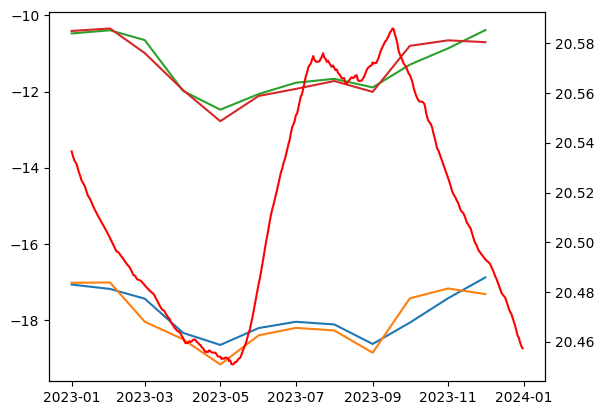

In [98]:
soil_year = df_soil["Bath_and_Bristol_cs_gb_TW_UK_ERA5_BASE_V2"].loc[[d.year == year for d in df_soil.index]]
fig, ax = plt.subplots(1)
ax.plot(df_mean["Bath and Bristol"])
ax2 = ax.twinx()
ax2.plot(soil_year, c="r")

In [106]:
soil_year.index = df_mean.index

ValueError: Length mismatch: Expected axis has 365 elements, new values have 12 elements

In [ ]:
soil_year.shape

(365,)